# Face Recognition: VGGFace

---
For the comparison model, we use VGGFace which has addon-libraries also available
in keras. VGGFace is also a convolutional neutral network, trained on 2.6M images
from 2.6k individuals (many more representations of the same individual than I have
in the celebrity dataset). There are two goals for this facial recognition:  

1. Determine if an individual is who they say they are
2. Determine if a photo matches an individual from a database.

In this notebook I demonstrate the separability of matching individuals with random
selections, as well as the ability to match input images against the celebrity database.

In [1]:
from FaceUtilities import *
import pandas as pd
from scipy.integrate import simpson

### 1. Model Predictions

---
The model is run over every image from the given directory and creates all of the feature vectors
a priori. Since this can take a while to complete, the data is then cached in an hdf5 file.

To compare two feature vectors to one another, the main metric to look at will be the n-dimensional
distance (depending on the size of the feature vector).

In [2]:
visage = FaceUtilities()
#visage.set_directory('data/CelebA/TestMTC/')
visage.set_directory('data/CelebA/ImgMTC/')
visage.load_vggface()

# Stripping out the excess attributes we aren't going to use
visage.labels = visage.labels[['filename', 'pid']]
visage.load_features(use_cache=True, cache_file='cached_img.h5')

Loading from cache: cached_img.h5


In [3]:
# False Rejection: We can use all of the pairs in the test set for this
def distance(featA, featB):
    return np.sum((featA - featB)**2)**0.5

### 2. Model Performance

---
The model is evaluated by producing a large set of matching faces as well as a large set of
random non-matching faces. From these we can infer a probability distribution and associated
cumulative distributions to produce an ROC curve, as well as select for a threshold.

The threshold choice would depend heavily on the application. In instances where facial recognition
might be used for security clearance (into a building for example), one would choose to accept
a higher false negative rate in order to achieve a very low false acceptance rate.

Referencing the plots output by the cell below:  
The top-left plot shows the distribution of feature vector distances of pairs of photos with matching
identification in blue, and the distribution of randomly paired (non-matching) images in orange. These
can be used to infer the relevant probability distributions.

The top-right plot are the associated cumulative distribution functions derived from the previous plot,
and can be used to determine where we might want to select a threshold for matching images.

The bottom-left plot contains the ROC curve, which is parameterized from the two CDF.

The bottom-right contains possible metrics to consider for a threshold, with the
detection sensitivity $TP / \sqrt{TP + FP}$, using the maximum of this distribution, a cutoff
is selected for defining the false acceptance and false rejection rates for the model.

Select individuals when features < 125.1
False Rejection: 0.084
False Acceptance: 0.065


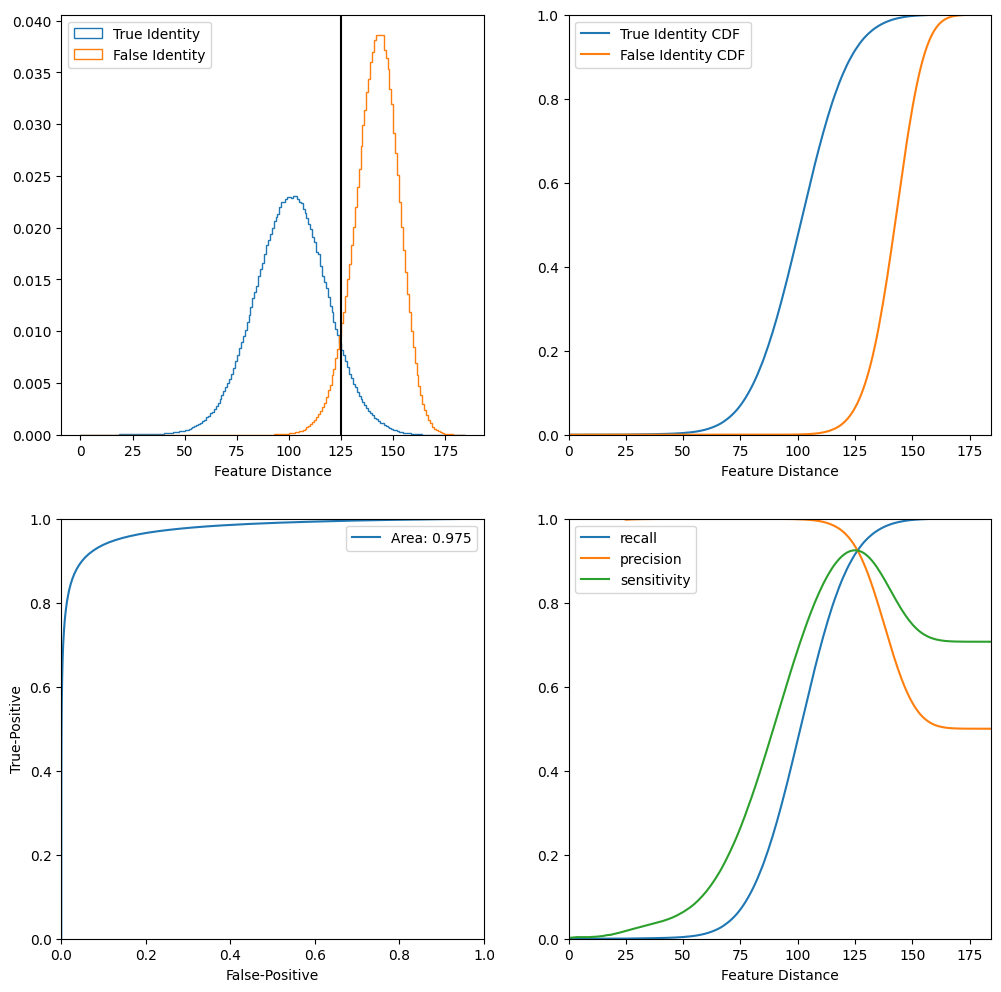

In [4]:
def test_vector_comparison(feature_function, name, **kwargs):
    fr, rr= visage.create_feature_metrics(feature_function)
    bins = np.linspace(0, np.max([max(fr), max(rr)]), 200)
    options = {'histtype':'step', 'bins':bins, 'density':True}
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    ytrue, xtrue, _ = ax[0,0].hist(fr, label="True Identity", **options)
    yfalse, xfalse, _ = ax[0,0].hist(rr, label="False Identity", **options)
    ax[0,0].set_xlabel("Feature Distance")
    ax[0,0].legend()
    #ax[0,0].set_yscale('log')
    
    true_cdf = np.cumsum(ytrue)
    true_cdf = true_cdf / np.max(true_cdf)
    false_cdf = np.cumsum(yfalse)
    false_cdf = false_cdf / np.max(false_cdf)
    
    integral_a = simpson(true_cdf, false_cdf)
    integral_b = simpson(false_cdf, true_cdf)
    if integral_b > integral_a:
        true_cdf = 1 - true_cdf
        false_cdf = 1 - false_cdf
        ax[1,0].plot(false_cdf, true_cdf, label=f'Area: {integral_b:0.3f}')
    else:
        ax[1,0].plot(false_cdf, true_cdf, label=f'Area: {integral_a:0.3f}')
    
    ax[1,0].set_xlim(0, 1)
    ax[1,0].set_ylim(0, 1)
    ax[1,0].set_ylabel("True-Positive")
    ax[1,0].set_xlabel("False-Positive")
    ax[1,0].legend()
    
    ## Cumulative Distributions
    ax[0,1].plot(bins[1:], true_cdf, label="True Identity CDF")
    ax[0,1].plot(bins[1:], false_cdf, label="False Identity CDF")
    ax[0,1].set_ylim(0, 1)
    ax[0,1].set_xlim(0, np.max(bins))
    ax[0,1].set_xlabel("Feature Distance")
    ax[0,1].legend()
    
    ##
    TP = true_cdf
    TN = 1 - false_cdf
    FP = false_cdf
    FN = 1 - true_cdf
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    sens = TP / np.sqrt(TP + FP)
    ax[1,1].plot(bins[1:], recall, label="recall")
    ax[1,1].plot(bins[1:], precision, label="precision")
    ax[1,1].plot(bins[1:], sens, label="sensitivity")
    ax[1,1].set_ylim(0, 1)
    ax[1,1].set_xlim(0, np.max(bins))
    ax[1,1].set_xlabel("Feature Distance")
    ax[1,1].legend()
    
    ## Choosing a cutoff
    cut_select = (sens == np.max(sens))
    cutoff = (bins[1:])[cut_select][0]
    ax[0,0].axvline(cutoff, color='black')
    false_rejection_rate = FN[cut_select][0]
    false_acceptance_rate = FP[cut_select][0]
    print(f'Select individuals when features < {cutoff:0.1f}')
    print(f'False Rejection: {false_rejection_rate:0.3f}')
    print(f'False Acceptance: {false_acceptance_rate:0.3f}')
    
    ## Metric choice:
    plt.show()
    
test_vector_comparison(distance, 'distance')

### 3. Doppleganger

---
The previous tests are for choosing a threshold to answer the question: "Is this person who
they say they are". The model could also be used to identify who someone might be (or is closest)
to in a database. The examples below show the top-5 closest images compared with an input image.
The input image is processed to find the face with mtcnn before comparing with every single feature
vector.

For this I chose myself (knowing that I am not in the database), a face of someone known to be
within the database (but using an external image), as well as my cat (to see how the model performs
given something entirely unexpected).

1/1 [==============================] - 0s 15ms/step


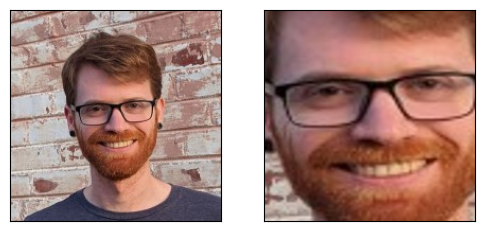

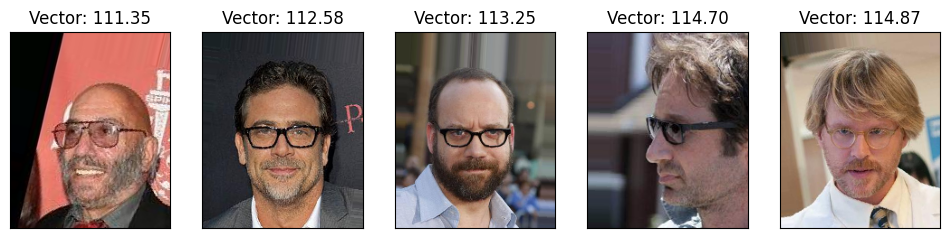

In [5]:
closeTest = visage.doppleganger('testimages/morgan.jpeg', distance)

1/1 [==============================] - 0s 13ms/step


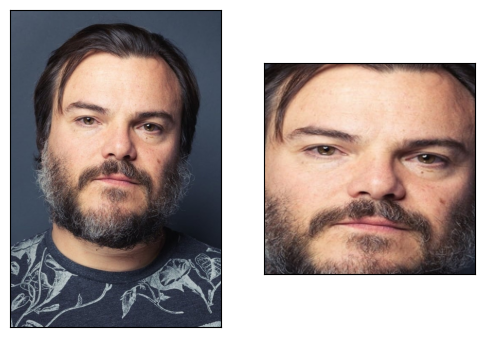

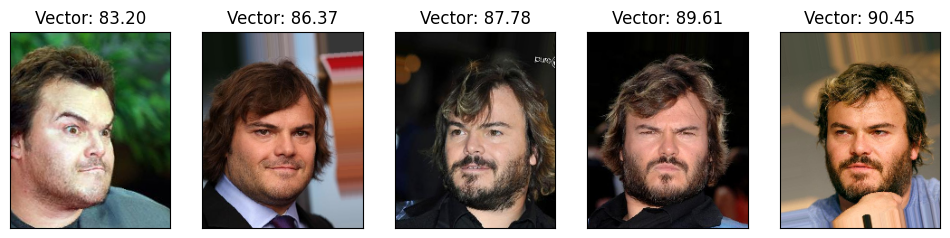

,index,filename,pid,features,closeness
0,2060,data/CelebA/Img/002818.png,4082,"[4.0078673, 0.035935916, 0.0, 0.4018466, 0.192...",83.196313
1,79954,data/CelebA/Img/111179.png,4082,"[2.334338, 0.0, 0.0, 0.5690647, 0.25688303, 6....",86.367481
2,100906,data/CelebA/Img/140392.png,4082,"[4.9672995, 0.0, 0.030280052, 0.33187255, 0.00...",87.784193
3,55087,data/CelebA/Img/076638.png,4082,"[3.9681957, 0.37485987, 0.16091801, 2.2828667,...",89.614855
4,15130,data/CelebA/Img/021073.png,4082,"[0.3136238, 0.20009655, 0.020386659, 1.7392875...",90.446505


In [6]:
visage.doppleganger('testimages/jackblack.jpg',distance)

1/1 [==============================] - 0s 14ms/step


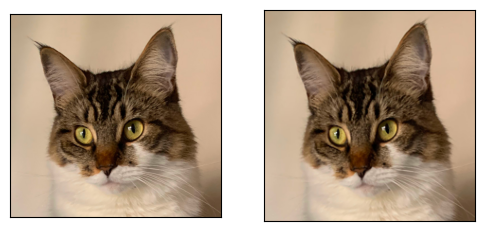

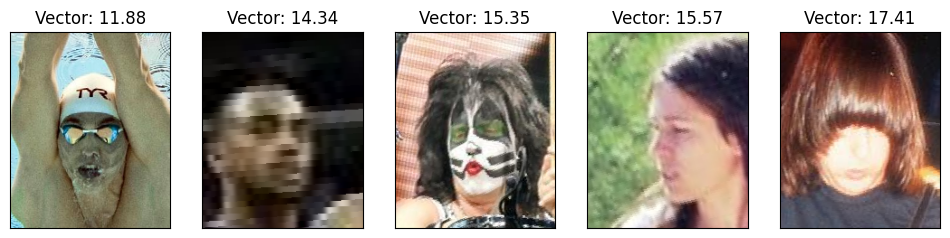

,index,filename,pid,features,closeness
0,100469,data/CelebA/Img/139803.png,1079,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02469301...",11.875032
1,52999,data/CelebA/Img/073720.png,834,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059...",14.343485
2,31798,data/CelebA/Img/044200.png,3006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011...",15.353088
3,87498,data/CelebA/Img/121690.png,7401,"[0.0, 0.0, 0.0030015244, 0.0, 0.0, 0.3391083, ...",15.566493
4,83790,data/CelebA/Img/116567.png,4827,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.83083963, 0.0, 0.0...",17.410997


In [7]:
visage.doppleganger('testimages/ash.jpeg',distance)

### Summary

---
The VGG model performs reasonably well, though there is still quite a lot of overlap in the probability distributions.
The matching of my own face and the known celebrity face into the database was as expected, with the results of the
feature distance showing that they are a closer match to themselves than I am to anyone in the selection. Interestingly,
my cat comes out with an extremely small feature distance to some of the photos (though fails the face detection algorithm
from mtcnn).

### Simple Model

---
Despite not training for very long and being a simplified model, it is interesting to see how the
model I created performs compared with the extensively trained network. Notably there is at least
some degree of feature extraction and separation, though the area under the ROC drops from 0.975
above to 0.810 below. Note that the test subject, Jack Black, was found in the training set above,
but because this model was actually trained using that data, these results are shown using the smaller
test set. Jack Black may or may not actually exist in this test set which may partially explain why
his images do not show up within the top 5 results.

Loading from cache: cached_test.h5
Select individuals when features < 1.1
False Rejection: 0.107
False Acceptance: 0.486


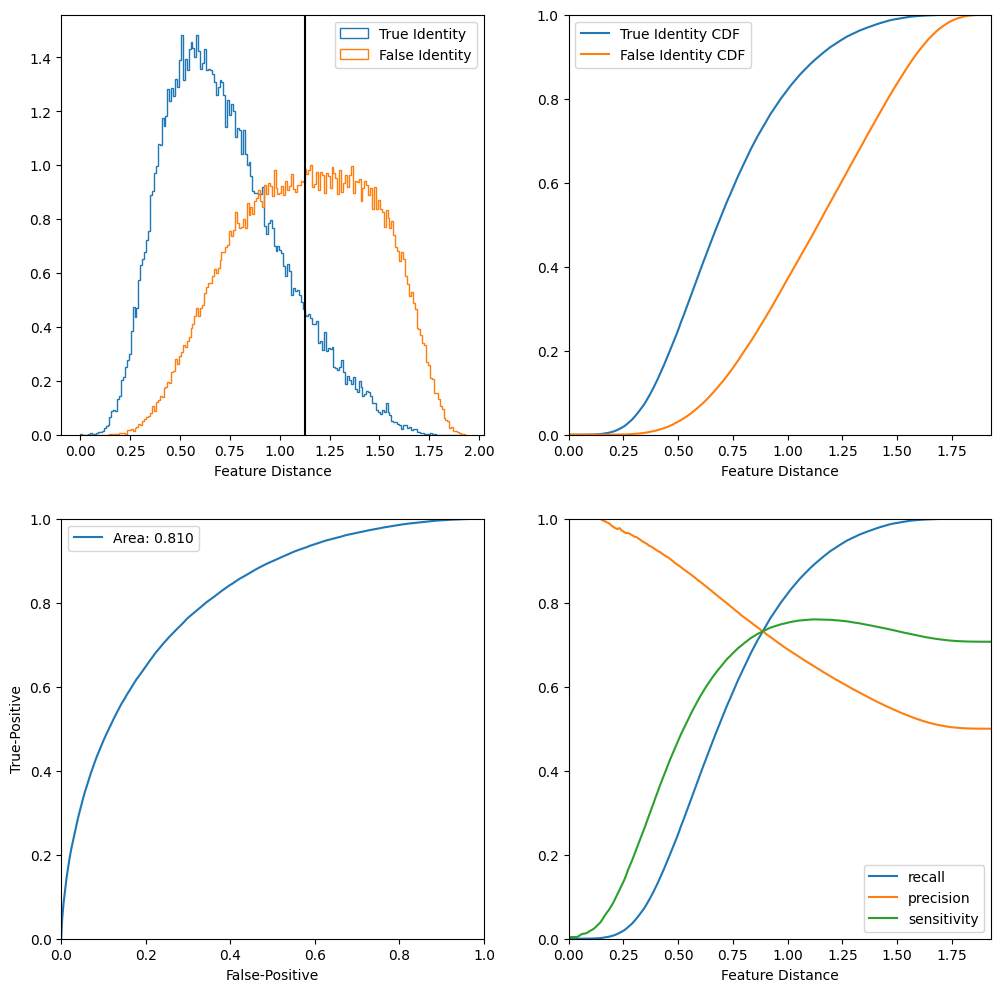

1/1 [==============================] - 0s 15ms/step


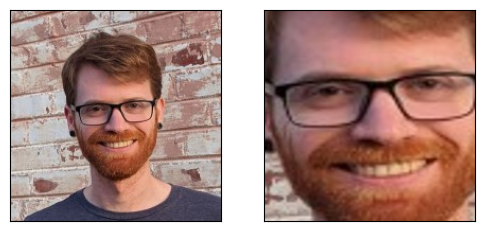

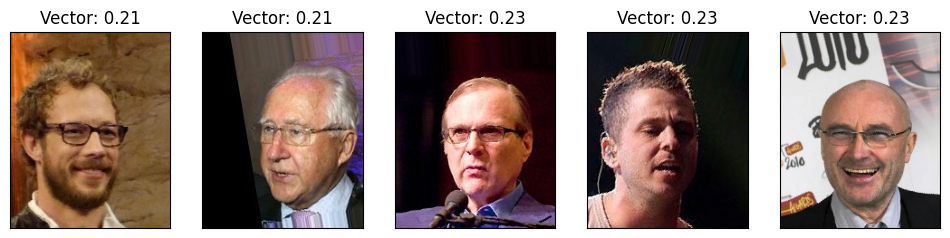

1/1 [==============================] - 0s 15ms/step


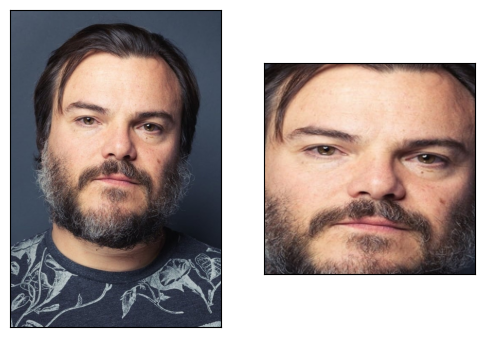

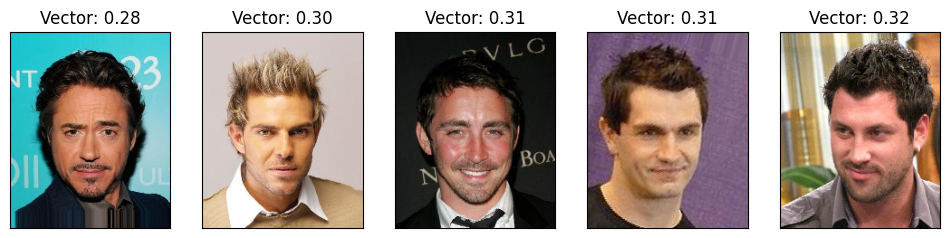

1/1 [==============================] - 0s 14ms/step


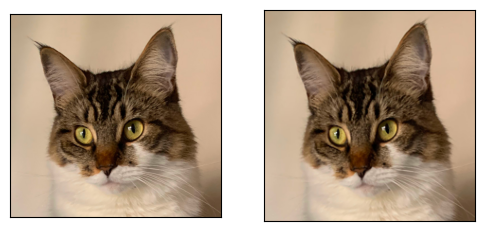

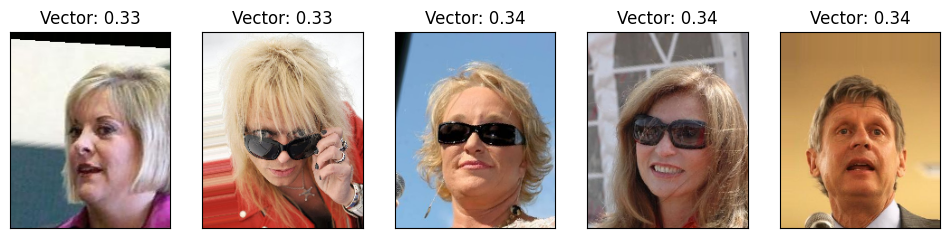

In [8]:
visage = FaceUtilities()
visage.set_directory('data/CelebA/TestMTC/')
visage.model = keras.models.load_model('p2model')

# Stripping out the excess attributes we aren't going to use
visage.labels = visage.labels[['filename', 'pid']]
visage.load_features(use_cache=True, cache_file='cached_test.h5')

test_vector_comparison(distance, 'distance')
closeTest = visage.doppleganger('testimages/morgan.jpeg', distance)
visage.doppleganger('testimages/jackblack.jpg',distance)
dpl = visage.doppleganger('testimages/ash.jpeg',distance)